In [4]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
import PIL
print(PIL.PILLOW_VERSION)


7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Aug 15 17:32:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [7]:
import pickle
import numpy as np
from skimage import io
import os

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torchvision
from torchvision import transforms, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Трансформеры данных

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
!unzip '/content/drive/MyDrive/data/journey-springfield.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

Загрузка датасетов

In [12]:
from torch.utils.data.sampler import SubsetRandomSampler

train_data_dir = '/content/train/simpsons_dataset'
train_dataset = datasets.ImageFolder(train_data_dir, data_transforms['train'])

test_data_dir = '/content/testset/'
test_dataset = datasets.ImageFolder(test_data_dir, data_transforms['test'])

random_seed= 42
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
val_indices, train_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loaders = {x[1]: torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                              shuffle=False, num_workers=2, sampler=x[0])
                for x in [[train_sampler, 'train'], [valid_sampler, 'valid']]}

test_loader = torch.utils.data.DataLoader(test_dataset,
                                              shuffle=False, num_workers=2)

Визуализация батча из train датасета

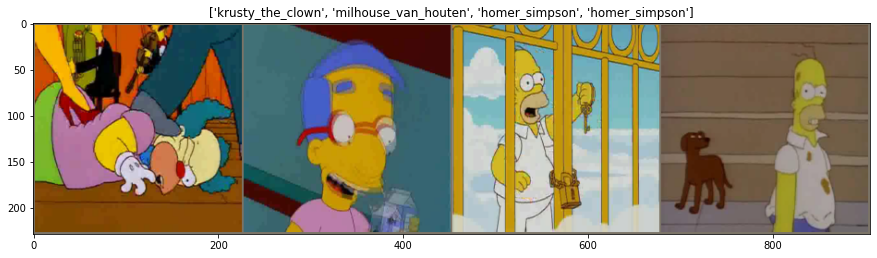

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(train_loaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
# кол-во определяемых классов
nclasses = len(os.listdir(train_data_dir))

In [14]:
class ConvNN(nn.Module):

  def __init__(self):
    super(ConvNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 8, 3, 1)
    self.conv2 = nn.Conv2d(8, 16, 3, 1)
    self.conv3 = nn.Conv2d(16, 32, 3, 1)
    # self.conv4 = nn.Conv2d(32, 64, 3, 1)
    self.pool = nn.MaxPool2d(2, 1)
    self.fc1 = nn.Linear(32 * 215 * 215, nclasses)
    # self.fc2 = nn.Linear(340, 120)
    self.fc3 = nn.Linear(120, nclasses)
    self.soft = nn.Softmax(1)

  def forwardPass(self, X):
    X = F.relu(self.pool(self.conv1(X)))
    X = F.relu(self.pool(self.conv2(X)))
    X = F.relu(self.pool(self.conv3(X)))
    # X = F.relu(self.pool(self.conv4(X)))
    # print(X.shape)
    X = X.view(-1, 32 * 215 * 215)

    X = self.fc1(X)
    # X = F.relu(self.fc1(X))
    # X = F.relu(self.fc2(X))
    # X = F.relu(self.fc3(X))
    # X = self.soft(X)
    return X

In [22]:
net = ConvNN().to(device)

In [ ]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(train_loader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net.forwardPass(X_batch)
 
        loss = loss_fn(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 500 батчей
        if i % 500 == 499:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0
    
print('Обучение закончено')

[1,   500] loss: 3.447
[1,  1000] loss: 2.274
[1,  1500] loss: 2.143
[1,  2000] loss: 1.985
[1,  2500] loss: 1.836
[1,  3000] loss: 1.785
[1,  3500] loss: 1.743
[1,  4000] loss: 1.700
[1,  4500] loss: 1.575
[1,  5000] loss: 1.513



[2,   500] loss: 0.982
[2,  1000] loss: 1.030
[2,  1500] loss: 1.055
[2,  2000] loss: 0.995
[2,  2500] loss: 0.966
[2,  3000] loss: 1.041
[2,  3500] loss: 0.976
[2,  4000] loss: 0.965
[2,  4500] loss: 0.944
[2,  5000] loss: 0.959



[3,   500] loss: 0.497
[3,  1000] loss: 0.588
[3,  1500] loss: 0.564
[3,  2000] loss: 0.548
[3,  2500] loss: 0.528
[3,  3000] loss: 0.545
[3,  3500] loss: 0.519
[3,  4000] loss: 0.573
[3,  4500] loss: 0.532
[3,  5000] loss: 0.512



[4,   500] loss: 0.313
[4,  1000] loss: 0.342
[4,  1500] loss: 0.318
[4,  2000] loss: 0.319
[4,  2500] loss: 0.269
[4,  3000] loss: 0.374
[4,  3500] loss: 0.321
[4,  4000] loss: 0.341
[4,  4500] loss: 0.329
[4,  5000] loss: 0.321



[5,   500] loss: 0.178
[5,  1000] loss: 0.195
[5,  1500] loss: 0.229
[5,  2000] loss: 0.198
[5,  2500] loss: 0.188
[5,  3000] loss: 0.176
[5,  3500] loss: 0.220
[5,  4000] loss: 0.215
[5,  4500] loss: 0.251
[5,  5000] loss: 0.210


Обучение закончено


In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 4            |        cudaMalloc retries: 5         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    8332 MB |   13750 MB |  112332 GB |  112324 GB |\n|       from large pool |    8331 MB |   13748 MB |  112241 GB |  112233 GB |\n|       from small pool |       0 MB |       2 MB |      90 GB |      90 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    8332 MB |   13750 MB |  112332 GB |  112324 GB |\n|       from large pool |    8331 MB |   13748 MB |

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/simpsons1.pth')

In [23]:
net.load_state_dict(torch.load('/content/drive/MyDrive/simpsons1.pth'))

<All keys matched successfully>

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        

        with torch.set_grad_enabled(False):
          outputs = model.forwardPass(inputs)
          loss = criterion(outputs, labels)
          preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def train(model, val_loader, epochs, batch_size):
    val_loader = val_loader

    history = []
    log_template = "\nEpoch {ep:03d} \
    val_loss {v_loss:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, 
                                           v_loss=val_loss, v_acc=val_acc))
            
    return history

In [51]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model.forwardPass(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [52]:
history = train(net, train_loaders['valid'], epochs=1, batch_size=4)

epoch:   0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

In [25]:
history

[(0.1058504817093132, tensor(0.9767, device='cuda:0', dtype=torch.float64))]

In [37]:
def predict_one_sample(model, inputs, device=device):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model.forwardPass(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [34]:
import random

In [38]:
random_characters = int(random.choice(val_indices))
ex_img, true_label = train_dataset[random_characters]
probs_im = predict_one_sample(net, ex_img.unsqueeze(0))

[20370]

In [1]:
idxs = list(map(int,val_indices))
imgs = [train_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(net, imgs)

NameError: ignored

In [ ]:
labels = [path.parent.name for path in self.files]
self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

In [54]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

FileNotFoundError: ignored

In [55]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [train_dataset[id][1] for id in idxs]

# preds_class = [label_encode.classes_[i] for i in y_pred]

In [56]:
y_pred

array([22, 27, 22, 15, 25, 28,  6, 22, 15, 20, 27, 37,  7,  4,  6, 16, 33,
       15, 22,  6])

In [57]:
actual_labels

[22, 27, 22, 15, 25, 28, 37, 22, 15, 20, 27, 37, 7, 4, 6, 16, 33, 15, 22, 6]

In [59]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred)


ValueError: ignored

In [32]:
train_loaders['valid']

In [ ]:
class DataLoader():

  def __init__(self, main_dir: str):
    
    self.main_dir = main_dr

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

train_data_dir = '/content/train/simpsons_dataset'
train_dataset = datasets.ImageFolder(train_data_dir, data_transforms['train'])

test_data_dir = '/content/testset/'
test_dataset = datasets.ImageFolder(test_data_dir, data_transforms['test'])

random_seed= 42
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
val_indices, train_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loaders = {x[1]: torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                              shuffle=False, num_workers=2, sampler=x[0])
                for x in [[train_sampler, 'train'], [valid_sampler, 'valid']]}

test_loader = torch.utils.data.DataLoader(test_dataset,
                                              shuffle=False, num_workers=2)